# Рыжова А. з3530903/90301 - практическая 3

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import tree,ensemble,model_selection,metrics,neighbors
import warnings
warnings.filterwarnings('ignore')

### 1. Выбрать набор данных для классификации. 
#### Для анализа был выбран набор данных "Аритмия" из первой практической работы

In [52]:
data = pd.read_csv('arrhythmia.csv', delimiter=';')[["sex","age","height","weight","QRS_duration","PR_interval","QT_interval","T_interval","P_interval","QRS","heart_rate","num_of_intrinsic_deflections","group"]]
data.head()

,sex,age,height,weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS,heart_rate,num_of_intrinsic_deflections,group
0,0,75,190,80,91,193,371,174,121,-16,63,32,8
1,1,56,165,64,81,174,401,149,39,25,53,24,6
2,0,54,172,95,138,163,386,185,102,96,75,24,10
3,0,55,175,94,100,202,380,179,143,28,71,48,1
4,0,75,190,80,88,181,360,177,103,-16,?,28,7


In [53]:
# заменим пропуски в heart_rate как в практической работе №1
data.loc[[4], ("heart_rate")] = 74

In [54]:
# проверка, что не осталось пустых значений
for column in data.columns:
    if any(data[column] == "?"):
        print("column: {0:10}  missing: {1:1}".format(column, (data[column] == "?").sum()))

In [55]:
# делим датасет на обучающую и тестовую выборки (с помощью функции train_test_split)
data=data.dropna()
train = data.iloc[:, 1:]
test = data.iloc[:, :1]
train_data, test_data, train_target, test_target = model_selection.train_test_split(train, test, test_size=0.2)
print('TRAIN:',train_data.shape, train_target.shape)
print('TEST: ', test_data.shape, test_target.shape)
test_target=test_target.to_numpy().flatten()

TRAIN: (361, 12) (361, 1)
TEST:  (91, 12) (91, 1)


### 2. Построить модель DecisionTreeClassifier и исследовать влияние параметров алгоритма на качество классификации (число уровней, минимальное число объектов узла). Привести оценки качества классификации на обучающем и тестовом наборе для полного и усеченного дерева. 

In [56]:
# модель DecisionTreeClassifier - класс, способный выполнять задачу классификации набора данных с более чем двумя классами
dtc = tree.DecisionTreeClassifier()
# строим модель на основе сета тренировочных данных
dtc.fit(train_data, train_target)
# предсказываем значения для тестовых данных
test_predicted = dtc.predict(test_data)
# строим отчет основных метрик классификации
print(metrics.classification_report(test_target, test_predicted, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted == test_target), test_predicted.shape[0]))

              precision    recall  f1-score   support

           0     0.7561    0.8158    0.7848        38
           1     0.8600    0.8113    0.8350        53

    accuracy                         0.8132        91
   macro avg     0.8080    0.8136    0.8099        91
weighted avg     0.8166    0.8132    0.8140        91

number of rights 74 of 91


In [57]:
# матрица ошибок (по матрице [[31, 5], [10, 45]] у нас 
# 5 ошибок 1 типа (модель предсказала положительный результат, на деле он отрицательный) 
# и 10 ошибок 2 типа  (модель предсказала отрицательный результат, на деле он положительный)) 
metrics.confusion_matrix(test_target, test_predicted)

array([[31,  7],
       [10, 43]])

In [58]:
# выводим важность показателей, участвующих в структуре дерева
for i in range(data.columns.size - 1):
     if dtc.feature_importances_[i] !=0:
             print(data.columns[i+1], '-', dtc.feature_importances_[i])

age - 0.0702563767377484
height - 0.5652259324470753
weight - 0.03770773522335316
QRS_duration - 0.07893833363354459
PR_interval - 0.02083694083694084
QT_interval - 0.05744235629634222
T_interval - 0.0811923558314627
P_interval - 0.013023088023088021
QRS - 0.018515433841520795
heart_rate - 0.03831994553237597
num_of_intrinsic_deflections - 0.008371985157699444
group - 0.010169516438848529


In [59]:
# строим модель DecisionTreeClassifier с макс. глубиной дерева = 4
dtc = tree.DecisionTreeClassifier(max_depth=4)
dtc.fit(train_data, train_target)
test_predicted = dtc.predict(test_data)
print(metrics.classification_report(test_target, test_predicted, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted == test_target),test_predicted.shape[0]))

              precision    recall  f1-score   support

           0     0.7949    0.8158    0.8052        38
           1     0.8654    0.8491    0.8571        53

    accuracy                         0.8352        91
   macro avg     0.8301    0.8324    0.8312        91
weighted avg     0.8359    0.8352    0.8355        91

number of rights 76 of 91


In [60]:
# матрица ошибок (по матрице [[31, 7], [8, 45]] у нас 
# 7 ошибок 1 типа и 8 ошибок 2 типа
metrics.confusion_matrix(test_target, test_predicted)

array([[31,  7],
       [ 8, 45]])

In [61]:
# выводим важность показателей, участвующих в структуре дерева
for i in range(data.columns.size - 1):
     if dtc.feature_importances_[i] !=0:
             print(data.columns[i+1], '-', dtc.feature_importances_[i])

age - 0.045678013499413465
height - 0.7765242991461803
weight - 0.03032283128330347
QRS_duration - 0.10290217829144298
heart_rate - 0.02874840010452595
group - 0.01582427767513382


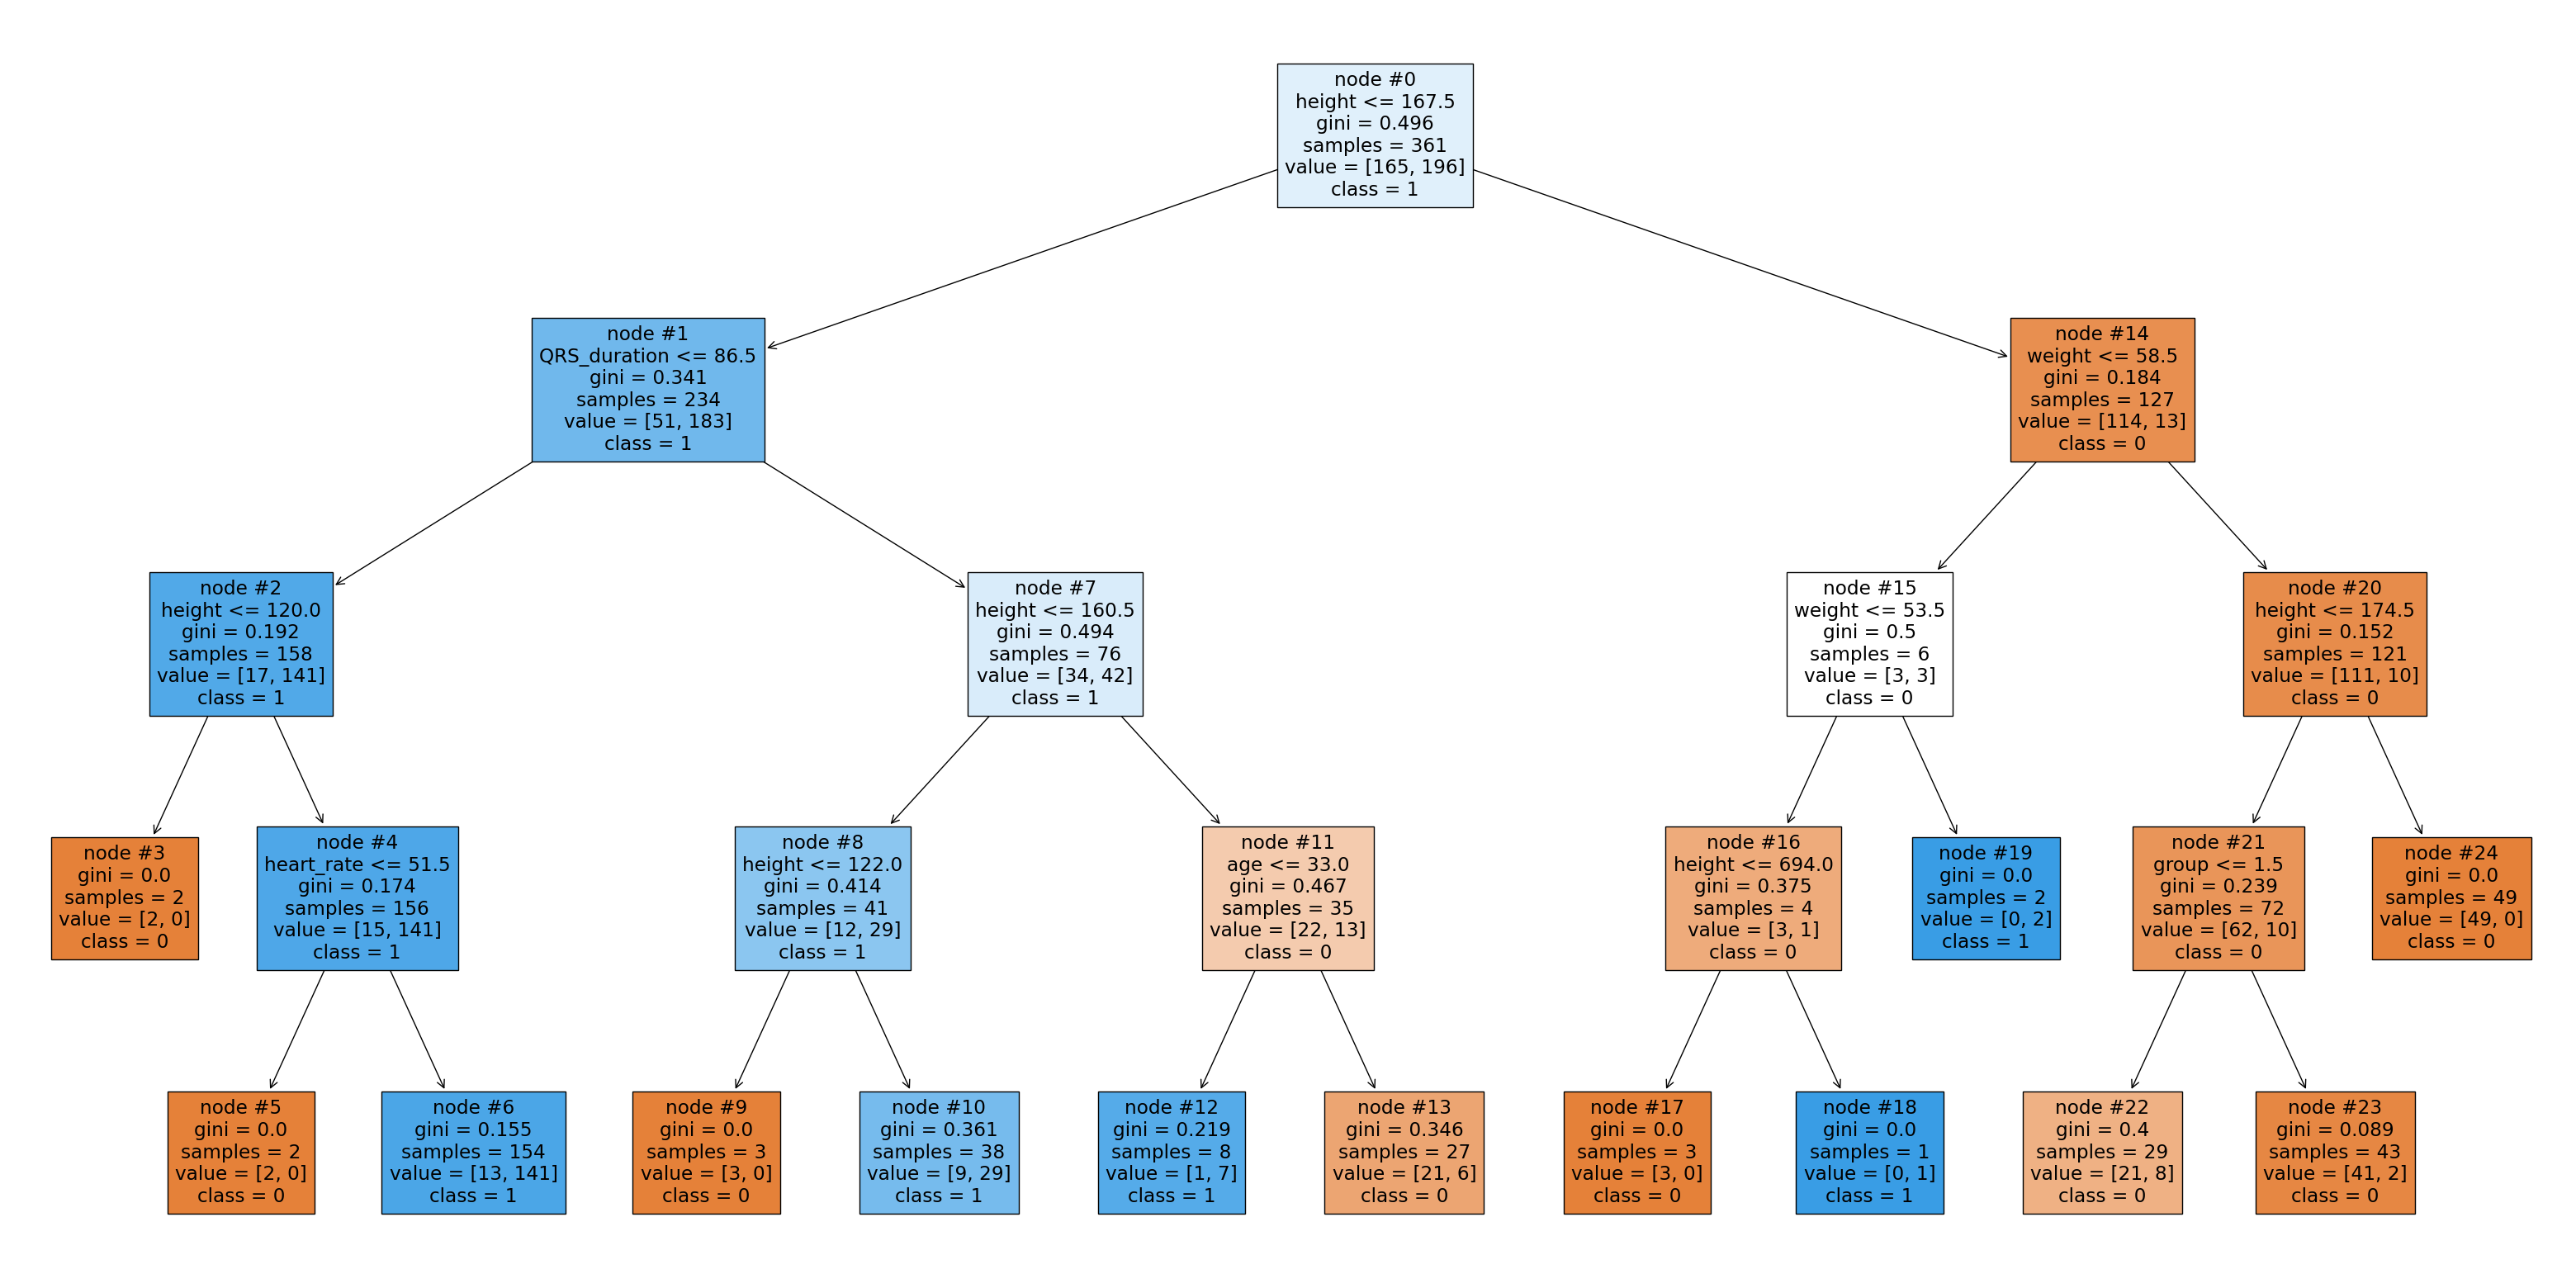

In [62]:
# строим график дерева с глубиной = 4
fig = plt.figure(figsize=(40, 20))
myplot = tree.plot_tree(dtc, feature_names=train.columns, class_names=['0','1'], filled=True, node_ids=True)

In [63]:
# ставим условие минимальное число объектов узла = 13
dtc = tree.DecisionTreeClassifier(min_samples_leaf=13)
dtc.fit(train_data,train_target)
test_predicted = dtc.predict(test_data)
print(metrics.classification_report(test_target, test_predicted, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted == test_target),test_predicted.shape[0]))

              precision    recall  f1-score   support

           0     0.7750    0.8158    0.7949        38
           1     0.8627    0.8302    0.8462        53

    accuracy                         0.8242        91
   macro avg     0.8189    0.8230    0.8205        91
weighted avg     0.8261    0.8242    0.8247        91

number of rights 75 of 91


In [64]:
# матрица ошибок (по матрице [[31, 7], [9, 44]] у нас 
# 9 ошибок 1 типа и 7 ошибок 2 типа)
metrics.confusion_matrix(test_target, test_predicted)

array([[31,  7],
       [ 9, 44]])

In [65]:
# выводим важность показателей, участвующих в структуре дерева
for i in range(data.columns.size - 1):
     if dtc.feature_importances_[i] !=0:
             print(data.columns[i+1], '-', dtc.feature_importances_[i])

age - 0.006201038085984214
height - 0.7600063680921829
weight - 0.04118703441355747
QRS_duration - 0.13406245418228538
PR_interval - 0.0011468482600117845
T_interval - 0.019991479546379986
QRS - 0.01699066898790321
heart_rate - 0.011130068359458829
group - 0.00928404007223627


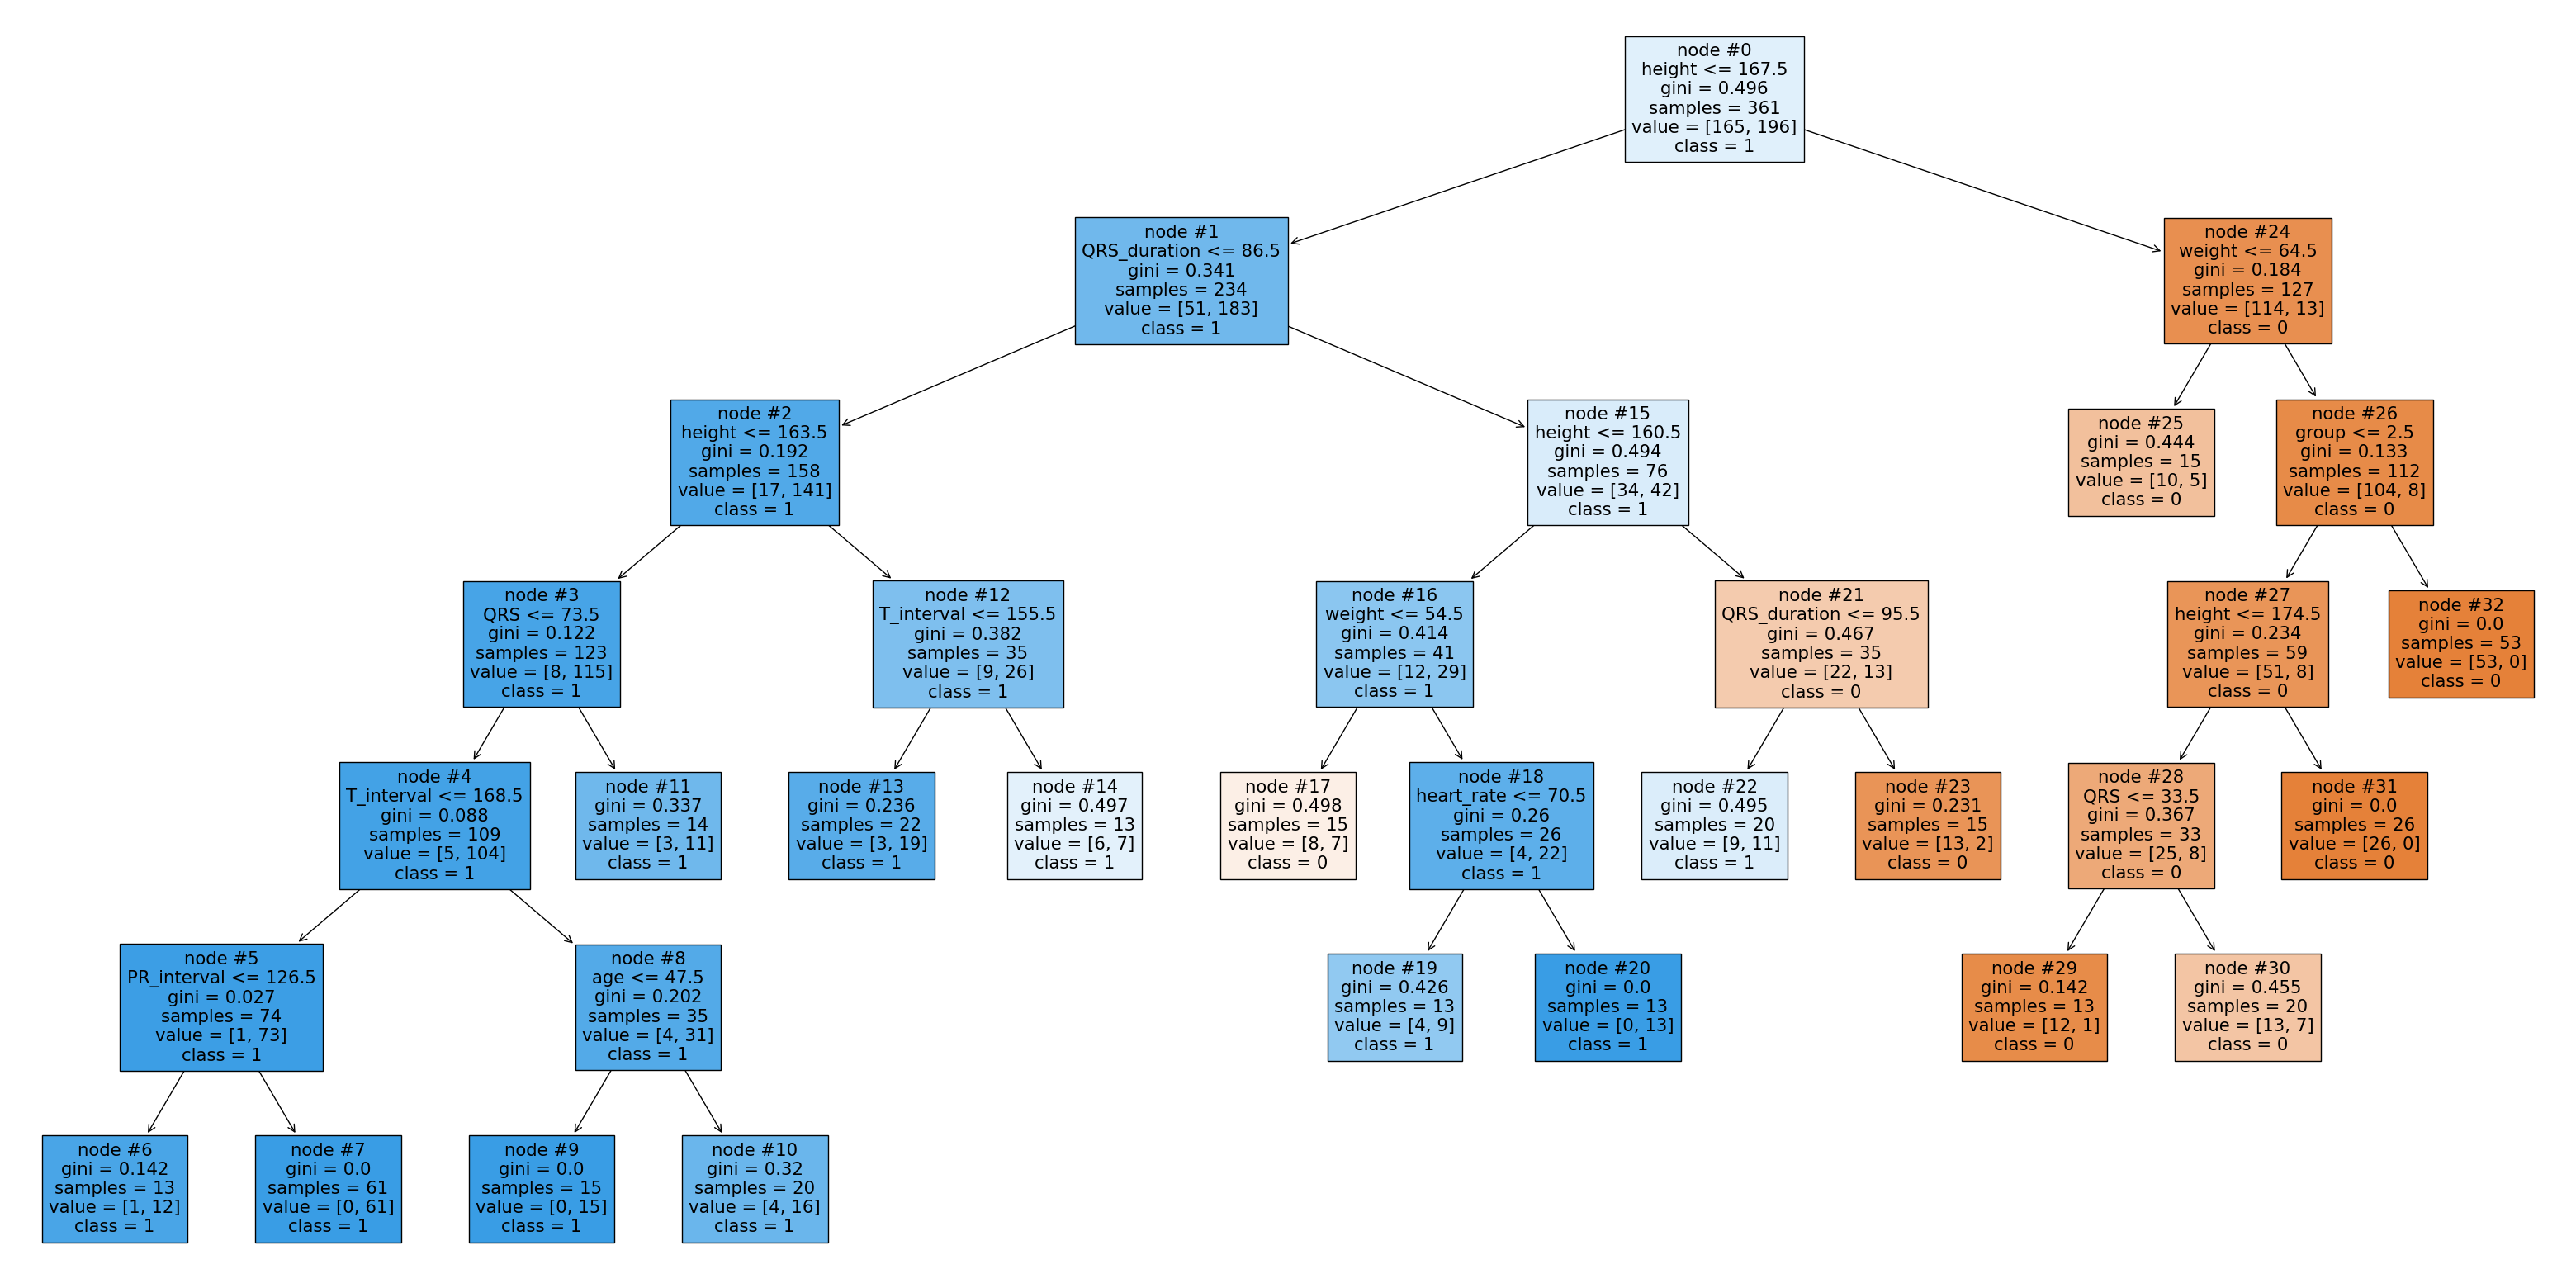

In [66]:
fig = plt.figure(figsize=(40, 20))
myplot = tree.plot_tree(dtc, feature_names=train.columns, class_names=['0','1'], filled=True, node_ids=True)

### 3. Построить модель RandomForest и исследовать влияние параметров алгоритма на качество классификации 

In [67]:
# модель RandomForest - основан на ансамбле деревьев решений (decision tree) для улучшения качества классификации 
rfc = ensemble.RandomForestClassifier()
rfc.fit(train_data,train_target.to_numpy().flatten())
test_predicted_rfc = rfc.predict(test_data)
print(metrics.classification_report(test_target, test_predicted_rfc, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted_rfc == test_target),test_predicted_rfc.shape[0]))

              precision    recall  f1-score   support

           0     0.8684    0.8684    0.8684        38
           1     0.9057    0.9057    0.9057        53

    accuracy                         0.8901        91
   macro avg     0.8870    0.8870    0.8870        91
weighted avg     0.8901    0.8901    0.8901        91

number of rights 81 of 91


In [68]:
# RandomForestClassifier с параметром количества деревьев decision tree (=60)
rfc = ensemble.RandomForestClassifier(n_estimators=60)
rfc.fit(train_data,train_target.to_numpy().flatten())
test_predicted_rfc = rfc.predict(test_data)
print(metrics.classification_report(test_target, test_predicted_rfc, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted_rfc == test_target),test_predicted_rfc.shape[0]))

              precision    recall  f1-score   support

           0     0.8140    0.9211    0.8642        38
           1     0.9375    0.8491    0.8911        53

    accuracy                         0.8791        91
   macro avg     0.8757    0.8851    0.8776        91
weighted avg     0.8859    0.8791    0.8799        91

number of rights 80 of 91


In [69]:
# RandomForestClassifier с параметром максимального количества показателей,
# участвующих в RandomForest на каждом разделении (=5)
rfc = ensemble.RandomForestClassifier(max_features=5)
rfc.fit(train_data,train_target.to_numpy().flatten())
test_predicted_rfc = rfc.predict(test_data)
print(metrics.classification_report(test_target, test_predicted_rfc, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted_rfc == test_target),test_predicted_rfc.shape[0]))

              precision    recall  f1-score   support

           0     0.8293    0.8947    0.8608        38
           1     0.9200    0.8679    0.8932        53

    accuracy                         0.8791        91
   macro avg     0.8746    0.8813    0.8770        91
weighted avg     0.8821    0.8791    0.8797        91

number of rights 80 of 91


In [70]:
# RandomForestClassifier с параметром максимальной глубины дерева (=4)
rfc = ensemble.RandomForestClassifier(max_depth=4)
rfc.fit(train_data, train_target.to_numpy().flatten())
test_predicted_rfc = rfc.predict(test_data)
print(metrics.classification_report(test_target, test_predicted_rfc, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted_rfc == test_target),test_predicted_rfc.shape[0]))

              precision    recall  f1-score   support

           0     0.8378    0.8158    0.8267        38
           1     0.8704    0.8868    0.8785        53

    accuracy                         0.8571        91
   macro avg     0.8541    0.8513    0.8526        91
weighted avg     0.8568    0.8571    0.8569        91

number of rights 78 of 91


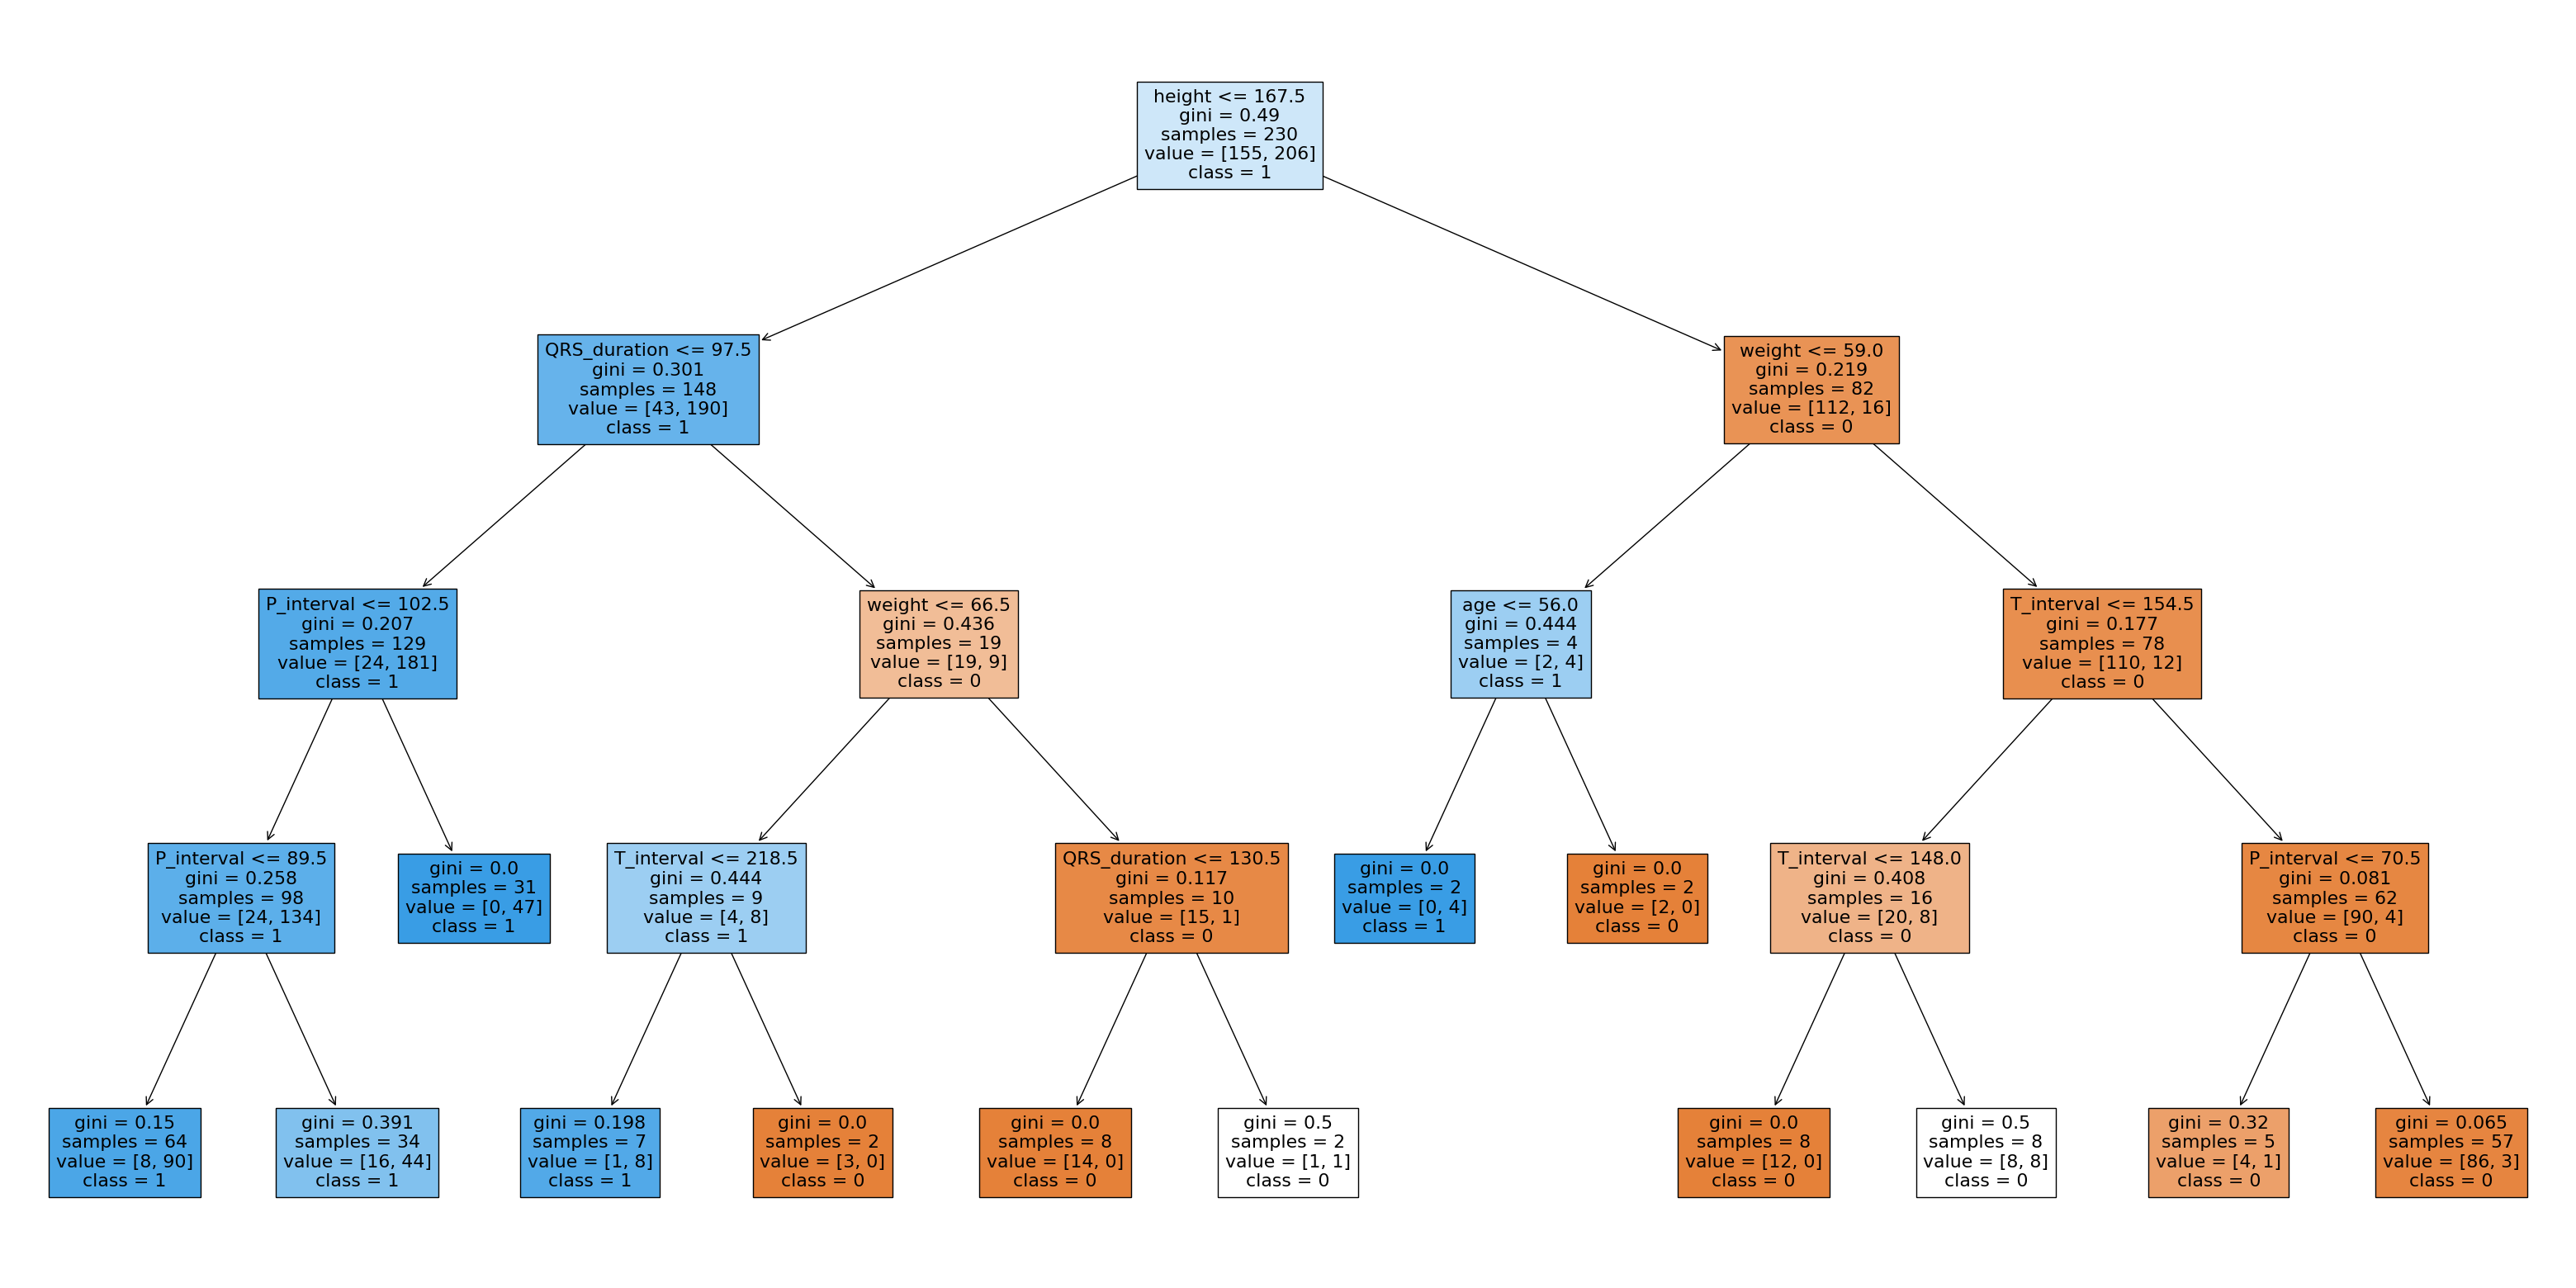

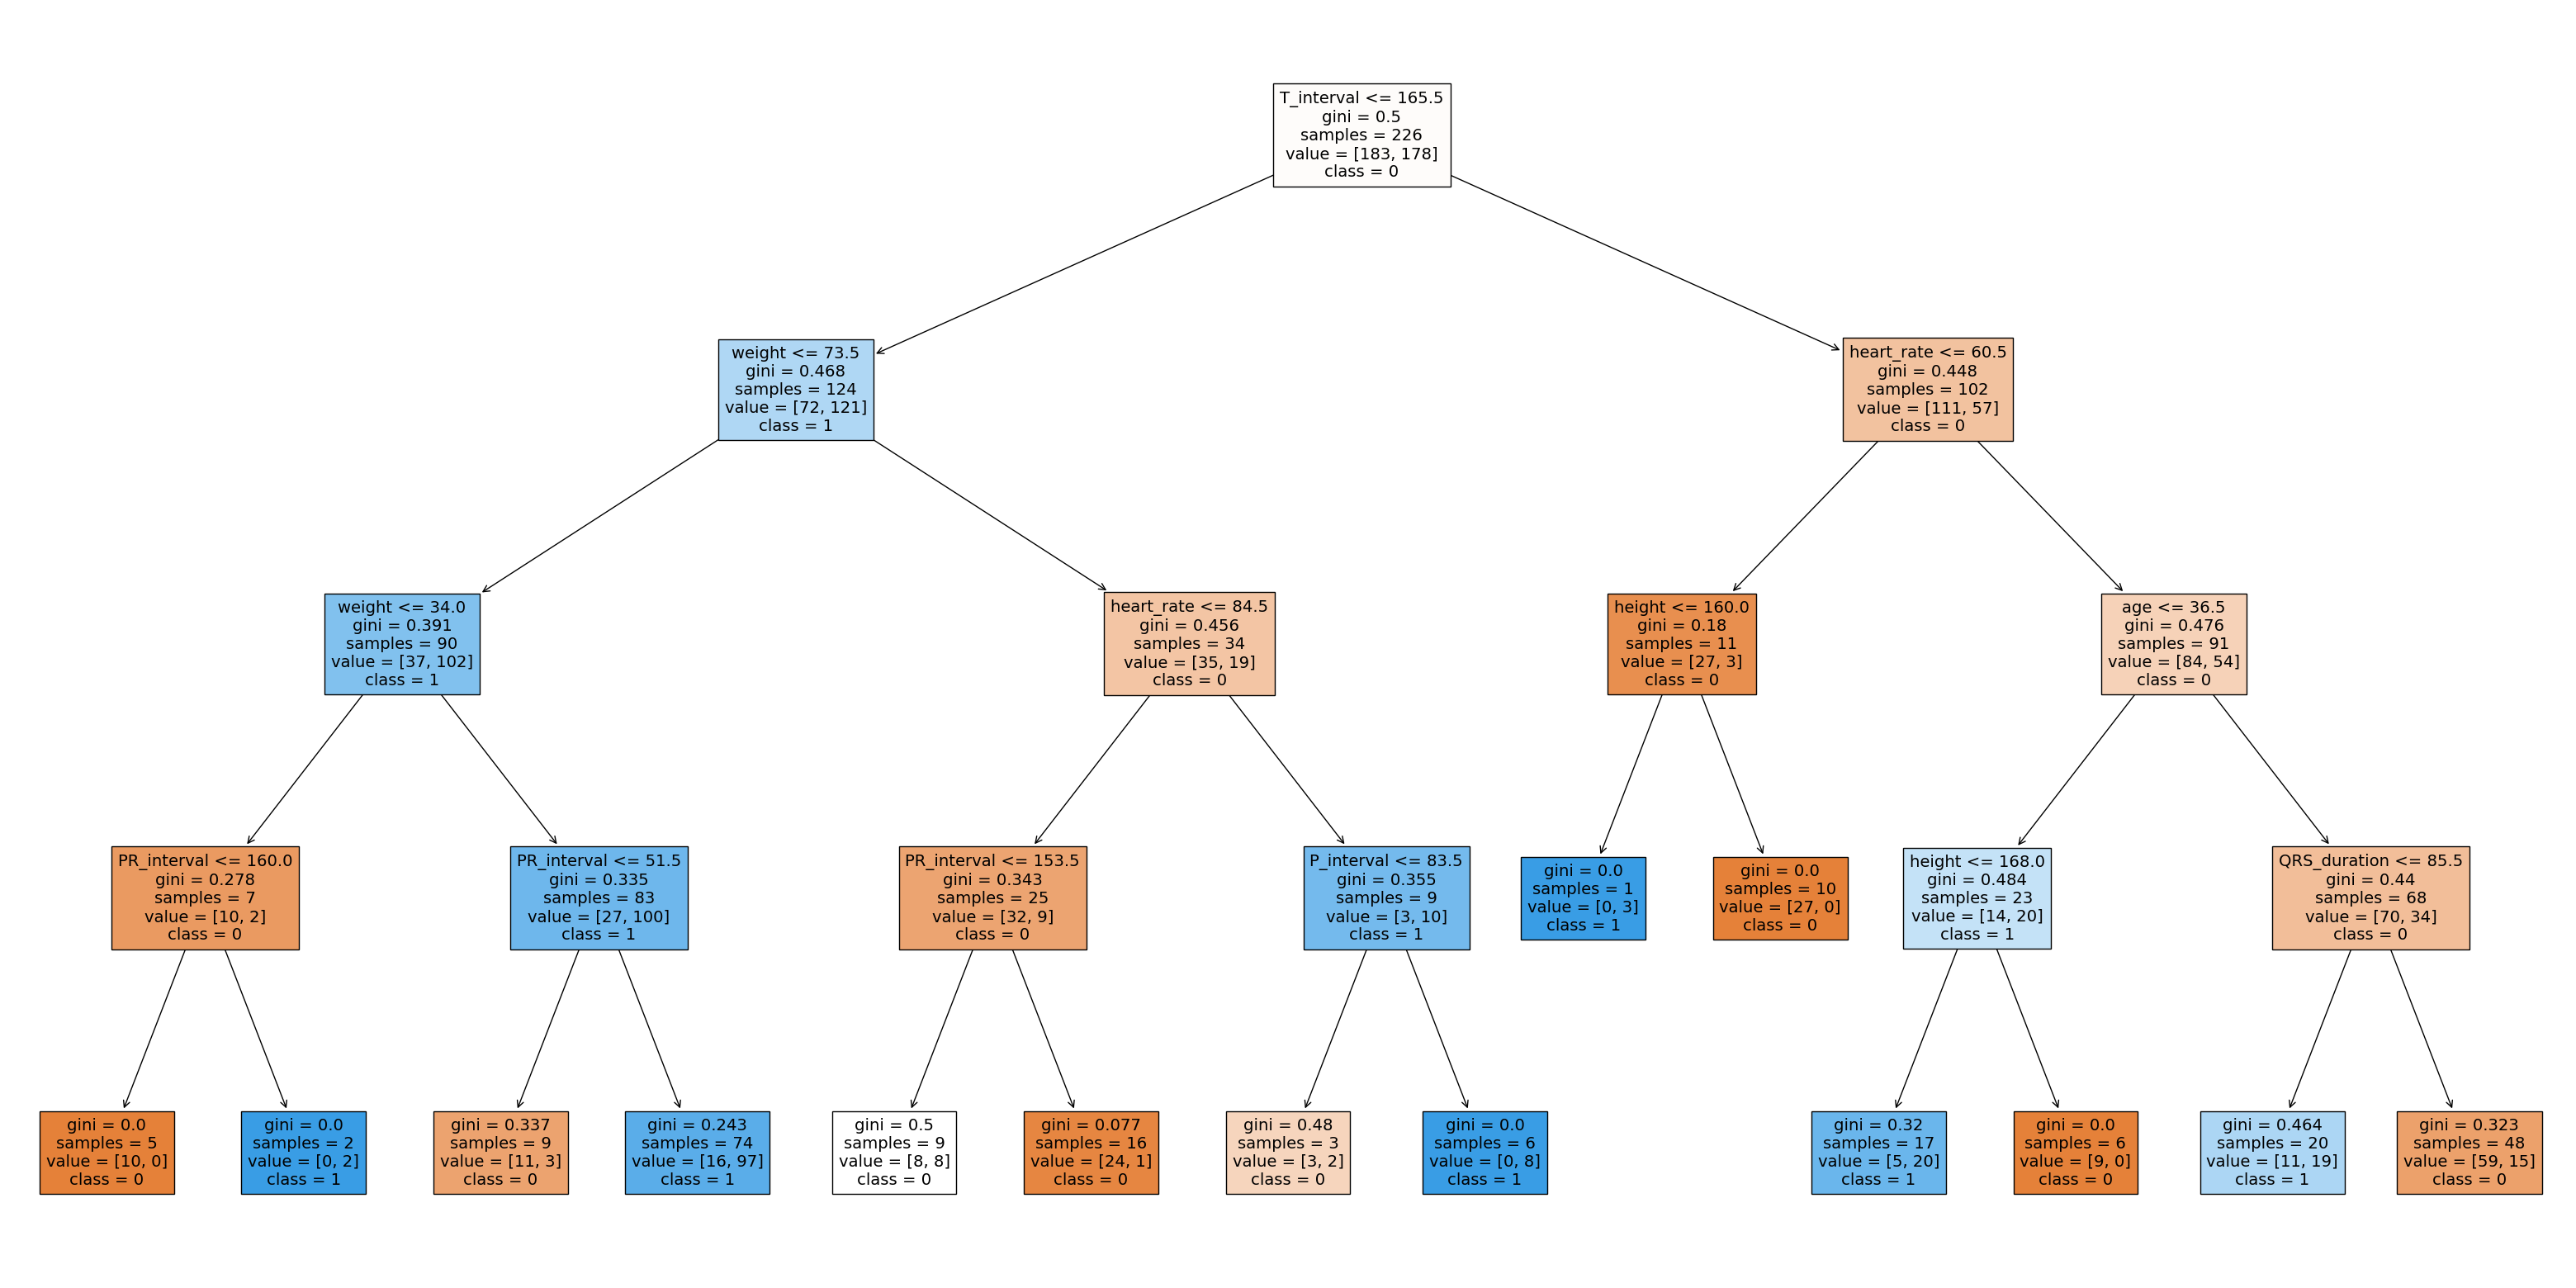

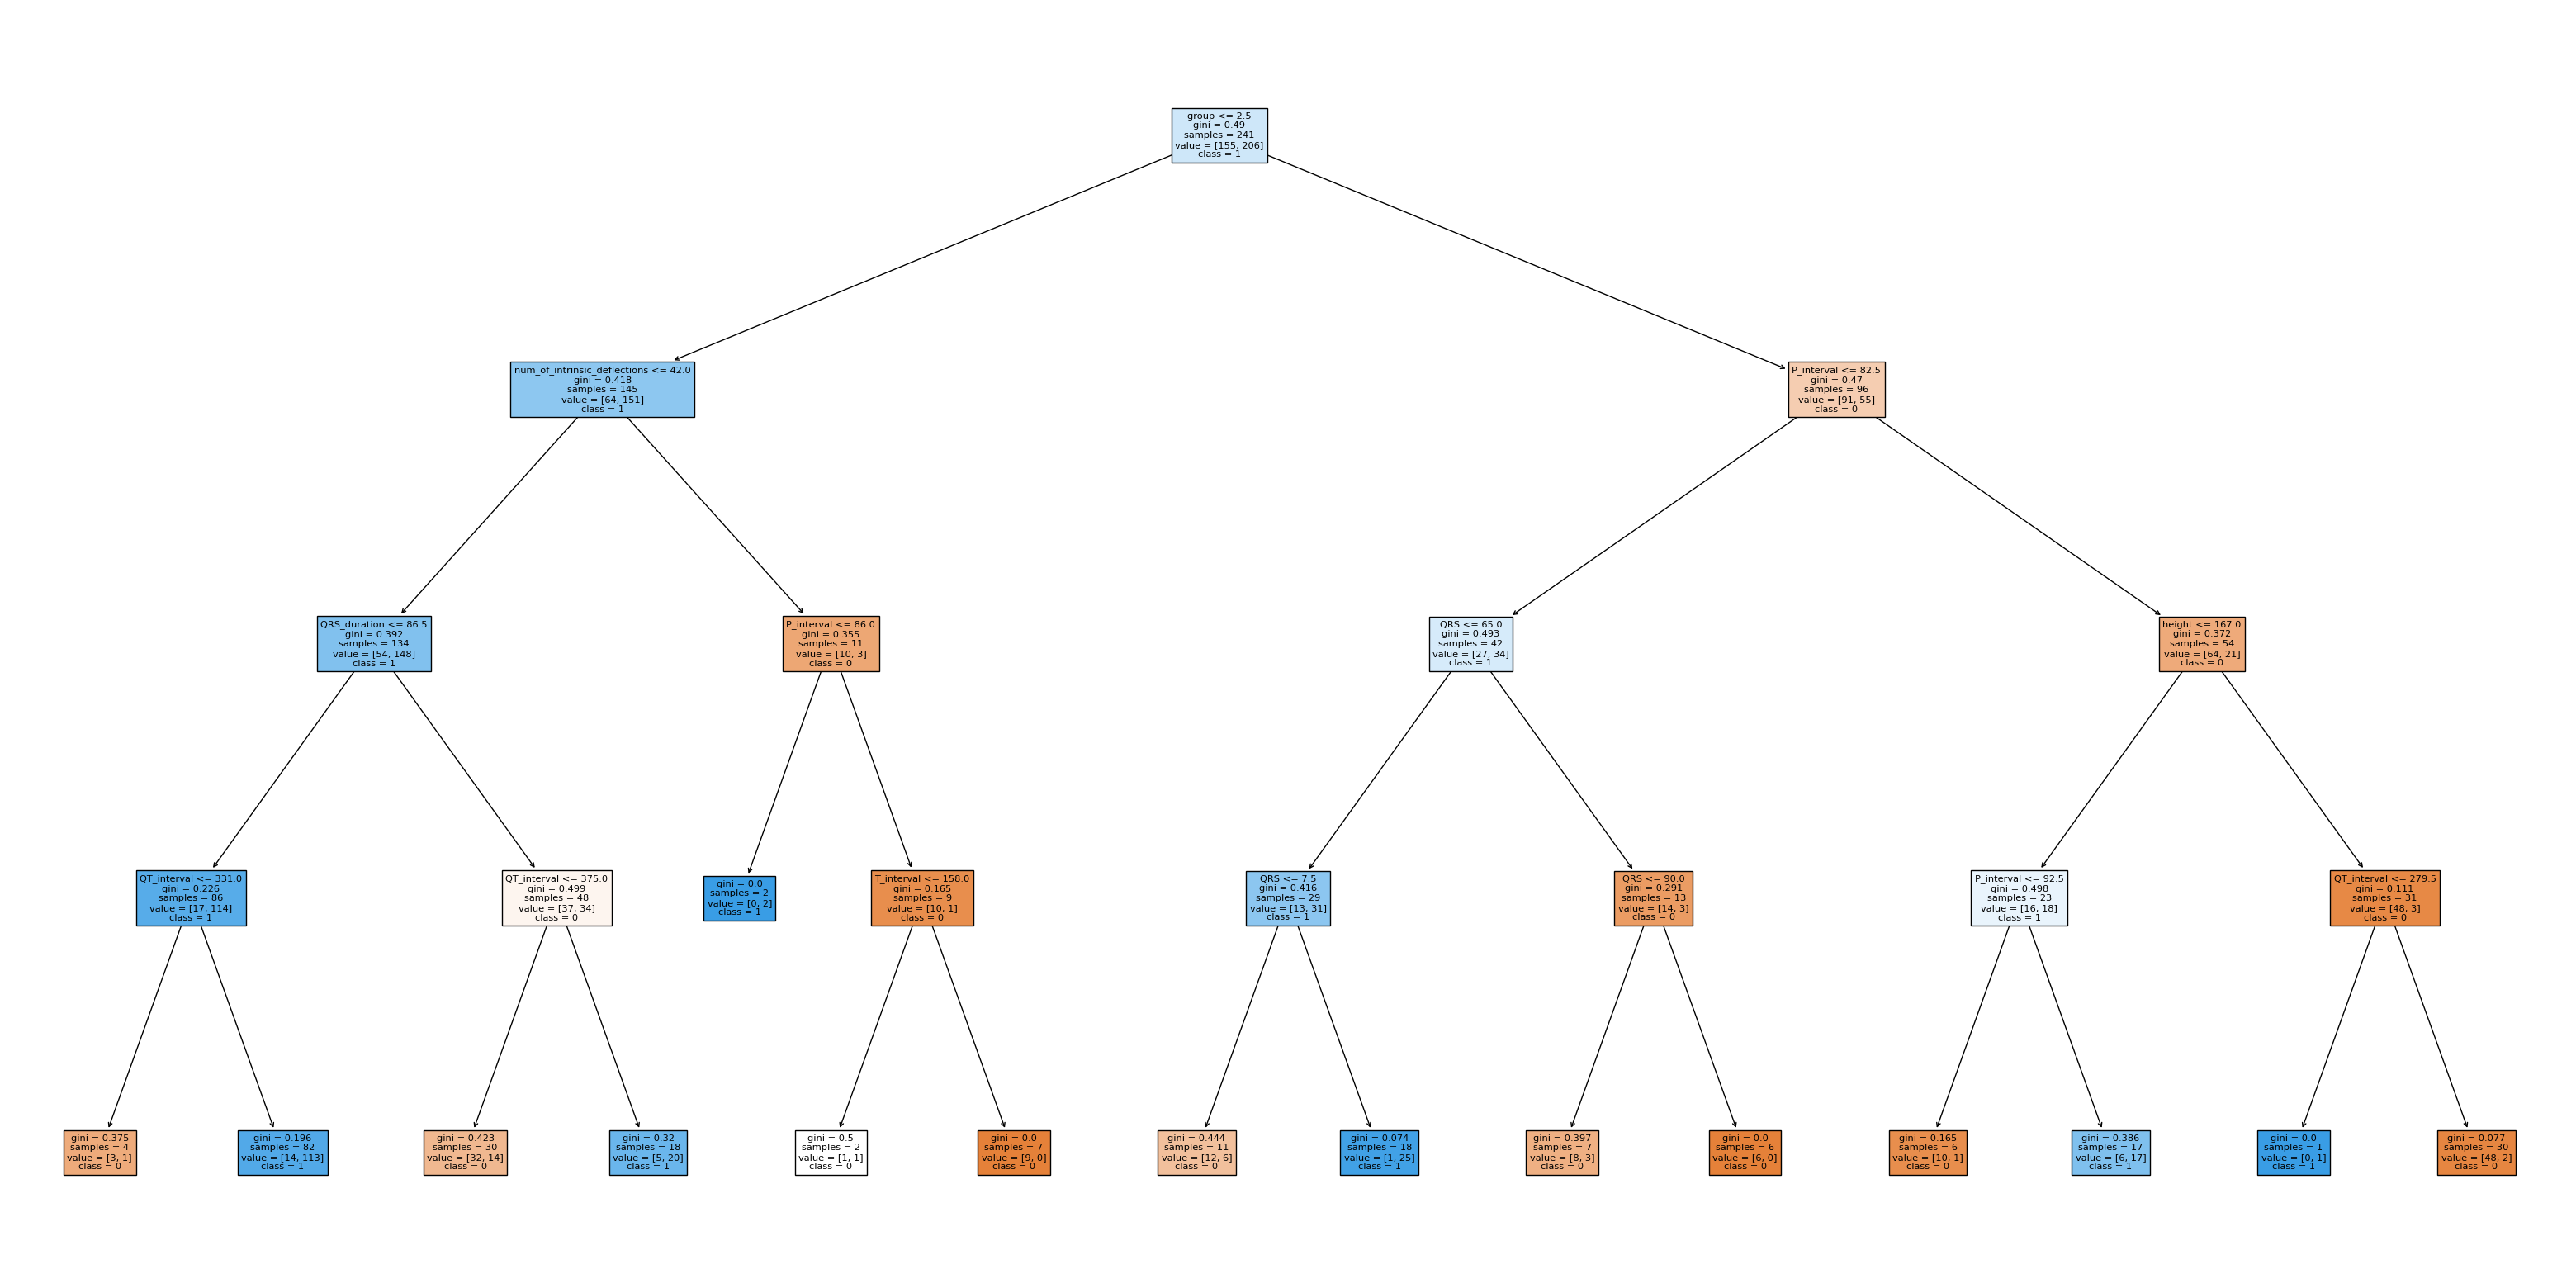

In [71]:
rfc = ensemble.RandomForestClassifier(max_depth=4)
rfc.fit(train_data,train_target.to_numpy().flatten())

# строим графики
for i in range(3):
    fig = plt.figure(figsize=(40, 20))
    # max n_estimators = 100 => чтобы вывести все листы умножаем на 49
    a = tree.plot_tree(rfc.estimators_[i*49], feature_names=train.columns, class_names=['0','1'], filled=True)

### 4. Получить оценки важности показателей с помощью модели RandomForest

In [72]:
# важность показателей последнего дерева
for i in range(data.columns.size - 1):
        if dtc.feature_importances_[i] !=0:
                print(data.columns[i+1], '-', dtc.feature_importances_[i])

age - 0.006201038085984214
height - 0.7600063680921829
weight - 0.04118703441355747
QRS_duration - 0.13406245418228538
PR_interval - 0.0011468482600117845
T_interval - 0.019991479546379986
QRS - 0.01699066898790321
heart_rate - 0.011130068359458829
group - 0.00928404007223627


In [73]:
px.box(data[['age','sex']], x='sex', y='age', title='Sex and age of subjects')

In [74]:
px.box(data[['QRS_duration','sex']], x='sex', y='QRS_duration', title='Sex and QRS_duration of subjects')

In [75]:
px.box(data[['group','sex']], x='sex', y='group', title='Sex and group of subjects')

### 5. Построить модели классификации одного типа (kNN, DecisionTree или др.) на полном наборе показателей, на 20% показателей с наибольшими оценками важности и на 80% показателей с наименьшими оценками важности

In [76]:
# строим дерево решений 
dtc_2 = tree.DecisionTreeClassifier()
dtc_2.fit(train_data,train_target)
test_predicted = dtc_2.predict(test_data)
print(metrics.classification_report(test_target, test_predicted, digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted == test_target),test_predicted.shape[0]))
# алгоритм сортировки оценок важностей показателей
sorted_indicators = []

for i in range(data.columns.size - 1):
    sorted_indicators.append((data.columns[i+1], dtc_2.feature_importances_[i]))

sorted_indicators = sorted(sorted_indicators, reverse=True, key=lambda elem: elem[1])
twenty = []
eighty = []

# всего показателей 12; 2 показателя = 20%
for i in range(2):
    twenty.append(sorted_indicators[i][0])

for i in range(2,len(sorted_indicators)):
    eighty.append(sorted_indicators[i][0])

              precision    recall  f1-score   support

           0     0.7949    0.8158    0.8052        38
           1     0.8654    0.8491    0.8571        53

    accuracy                         0.8352        91
   macro avg     0.8301    0.8324    0.8312        91
weighted avg     0.8359    0.8352    0.8355        91

number of rights 76 of 91


In [77]:
# дерево решений для 20% показателей с наибольшими оценками важности
dtc_2 = tree.DecisionTreeClassifier()
dtc_2.fit(train_data[twenty],train_target)
test_predicted = dtc_2.predict(test_data[twenty])
print(metrics.classification_report(test_target,test_predicted,digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted == test_target), test_predicted.shape[0]))

              precision    recall  f1-score   support

           0     0.7778    0.7368    0.7568        38
           1     0.8182    0.8491    0.8333        53

    accuracy                         0.8022        91
   macro avg     0.7980    0.7929    0.7950        91
weighted avg     0.8013    0.8022    0.8014        91

number of rights 73 of 91


In [78]:
# дерево решений для 80% показателей с наименьшими оценками важности
dtc_2 = tree.DecisionTreeClassifier()
dtc_2.fit(train_data[eighty],train_target)
test_predicted = dtc_2.predict(test_data[eighty])
print(metrics.classification_report(test_target,test_predicted,digits=4))
print('number of rights {0} of {1}'.format(sum(test_predicted == test_target), test_predicted.shape[0]))

              precision    recall  f1-score   support

           0     0.6486    0.6316    0.6400        38
           1     0.7407    0.7547    0.7477        53

    accuracy                         0.7033        91
   macro avg     0.6947    0.6931    0.6938        91
weighted avg     0.7023    0.7033    0.7027        91

number of rights 64 of 91
